In [158]:
import glob
import os
import librosa
import numpy as np
import seaborn as sns
import wave
import contextlib
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,f1_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

# Features plots - Code

In [159]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

# Extracting features

In [160]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    #print(chroma.shape)
    #print("chroma")
    #print(mfccs.shape)
    #print("mfccs")
    #print(mel.shape)
    #print("mels")
    #print(contrast.shape)
    #print("contrast")
    #print(tonnetz.shape)
    #print("tonnetz")    
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    d=0
    duration1 = []
    duration2 = []
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            with contextlib.closing(wave.open(fn,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                print(pd.Series(fn.split('_')).unique())
                print(d,duration)
                d=d+1
                print(" ")
                #dn=0
                if(sub_dir!='noise_set'):
                    #if(duration<0):
                    #    dn =dn+1
                    duration1.append(duration)  
                else:
                    duration2.append(duration)
            
    return duration1,duration2

In [161]:
def parse_audio_files2(parent_dir,sub_dirs,file_ext='*.wav'):
    features = np.empty((0,193))
    finlabel = np.empty((0,3))
    labells=[]
    labells1=np.empty(0) 
    labells2=np.empty(0) 
    d=0
    fns = []
    labels=[]
    label1s=[]
    label2s=[]
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          #  print("ext_features")
          #  print(ext_features.shape)
            features = np.vstack([features,ext_features])
          #  print("features")
          #  print(features.shape)
            if(sub_dir!='noise_set'):
                    d = d+1
                    if (len(fn.split('_'))>=6):
                        label1 = "1"
                    else:
                        label1="0"
                    label="1"
                    if(sub_dir=='TRIM_old'):
                        if(fn.split('_')[-1]=='2.wav' ):
                            label2="2"
                        if(fn.split('_')[3]=='Multiplepeacock'):
                            label2 = "4"
                        else:
                            label2 ="1"
                    else:
                        if(fn.split('_')[-1]=='1.wav'):
                            label2="1"
                        elif(fn.split('_')[-1]=='2.wav'):
                            label2 ="2" 
                        elif(fn.split('_')[-1]=='3.wav'):
                            label2 ="3"
                        elif(fn.split('_')[-1]=='MI.wav' or fn.split('_')[-1]=='3or4.wav'):
                            label2 ="4"                        
                        else:
                            label2 ="0"
                            
            else:
                label ="0"
                label1="1"
                label2 ="0"
            fns.append(fn.split('_')[1:])
            use = np.hstack([label,label1,label2])
            finlabel = np.vstack([finlabel,use])
            labels.append(label)
            label1s.append(label1)
            label2s.append(label2)
    return(fns, np.array(features), np.array(finlabel),np.array(labels), np.array(label1s), np.array(label2s))

> #  Feed Train & Test Data 

In [162]:
parent_dir = '../input/data-w/data/data'

sub_dirs = ['C_new2','TRIM_old','A_new1','trimmed_new3','noise_set','Chincholi','iid','Kaan'] #train dirs
duration1,duration2= parse_audio_files(parent_dir,sub_dirs)

['../input/data-w/data/data/C' 'new2/03' 'SN' 'peacock' 'disturbance'
 '2.wav']
0 0.36378125
 
['../input/data-w/data/data/C' 'new2/12' ' Eow' 'peacock' '1.wav']
1 0.4250625
 
['../input/data-w/data/data/C' 'new2/17' 'Eow' 'peacock' 'disturbance'
 '2.wav']
2 7.5035625
 
['../input/data-w/data/data/C' 'new2/30' 'SN' 'peacock' '1.wav']
3 0.283375
 
['../input/data-w/data/data/C' 'new2/33' 'Eow' 'peacock' '1.wav']
4 0.60415625
 
['../input/data-w/data/data/C' 'new2/13' 'Eow' 'peacock' '1.wav']
5 8.26509375
 
['../input/data-w/data/data/C' 'new2/23' 'SN' 'peacock' 'disturbance'
 '2.wav']
6 0.36996875
 
['../input/data-w/data/data/C' 'new2/19' 'SN' 'peacock' '1.wav']
7 0.4014375
 
['../input/data-w/data/data/C' 'new2/34' 'Eow' 'peacock' 'disturbance'
 '2.wav']
8 0.680875
 
['../input/data-w/data/data/C' 'new2/27' 'SN' 'peacock' 'otherbird'
 '2.wav']
9 0.31878125
 
['../input/data-w/data/data/C' 'new2/06' 'SN' 'peacock' 'disturbance'
 '2.wav']
10 0.40828125
 
['../input/data-w/data/data/C' '

142 5.0
 
['../input/data-w/data/data/noise' 'set/5-241846-A-15.wav']
143 5.0
 
['../input/data-w/data/data/noise' 'set/3-166125-B-23.wav']
144 5.0
 
['../input/data-w/data/data/noise' 'set/1-13613-A-37.wav']
145 5.0
 
['../input/data-w/data/data/noise' 'set/5-186924-A-12.wav']
146 5.0
 
['../input/data-w/data/data/noise' 'set/5-194899-B-3.wav']
147 5.0
 
['../input/data-w/data/data/noise' 'set/5-243025-A-25.wav']
148 5.0
 
['../input/data-w/data/data/noise' 'set/4-171823-A-13.wav']
149 5.0
 
['../input/data-w/data/data/noise' 'set/4-208021-A-1.wav']
150 5.0
 
['../input/data-w/data/data/noise' 'set/5-243448-A-14.wav']
151 5.0
 
['../input/data-w/data/data/noise' 'set/4-213915-A-3.wav']
152 5.0
 
['../input/data-w/data/data/noise' 'set/2-109759-B-26.wav']
153 5.0
 
['../input/data-w/data/data/noise' 'set/4-182039-A-30.wav']
154 5.0
 
['../input/data-w/data/data/noise' 'set/1-54918-B-14.wav']
155 5.0
 
['../input/data-w/data/data/noise' 'set/5-173568-A-33.wav']
156 5.0
 
['../input/data

['../input/data-w/data/data/noise' 'set/2-82274-A-5.wav']
294 5.0
 
['../input/data-w/data/data/noise' 'set/3-97909-A-49.wav']
295 5.0
 
['../input/data-w/data/data/noise' 'set/3-95698-A-5.wav']
296 5.0
 
['../input/data-w/data/data/noise' 'set/3-197435-B-22.wav']
297 5.0
 
['../input/data-w/data/data/noise' 'set/3-155642-A-11.wav']
298 5.0
 
['../input/data-w/data/data/noise' 'set/4-149940-B-5.wav']
299 5.0
 
['../input/data-w/data/data/noise' 'set/4-186693-A-17.wav']
300 5.0
 
['../input/data-w/data/data/noise' 'set/5-212734-A-17.wav']
301 5.0
 
['../input/data-w/data/data/noise' 'set/5-233019-A-31.wav']
302 5.0
 
['../input/data-w/data/data/noise' 'set/3-151273-A-35.wav']
303 5.0
 
['../input/data-w/data/data/noise' 'set/1-67230-A-29.wav']
304 5.0
 
['../input/data-w/data/data/noise' 'set/3-110913-B-7.wav']
305 5.0
 
['../input/data-w/data/data/noise' 'set/1-30830-A-24.wav']
306 5.0
 
['../input/data-w/data/data/noise' 'set/3-117293-A-9.wav']
307 5.0
 
['../input/data-w/data/data/no

['../input/data-w/data/data/noise' 'set/2-122066-A-45.wav']
443 5.0
 
['../input/data-w/data/data/noise' 'set/4-218199-B-35.wav']
444 5.0
 
['../input/data-w/data/data/noise' 'set/3-102908-A-4.wav']
445 5.0
 
['../input/data-w/data/data/noise' 'set/3-253084-E-2.wav']
446 5.0
 
['../input/data-w/data/data/noise' 'set/4-136381-A-9.wav']
447 5.0
 
['../input/data-w/data/data/noise' 'set/4-154443-A-24.wav']
448 5.0
 
['../input/data-w/data/data/noise' 'set/2-91912-A-33.wav']
449 5.0
 
['../input/data-w/data/data/noise' 'set/4-167063-B-11.wav']
450 5.0
 
['../input/data-w/data/data/noise' 'set/1-88574-A-8.wav']
451 5.0
 
['../input/data-w/data/data/noise' 'set/2-80482-A-20.wav']
452 5.0
 
['../input/data-w/data/data/noise' 'set/5-117122-A-42.wav']
453 5.0
 
['../input/data-w/data/data/noise' 'set/1-85123-A-31.wav']
454 5.0
 
['../input/data-w/data/data/noise' 'set/2-108767-A-9.wav']
455 5.0
 
['../input/data-w/data/data/noise' 'set/5-181458-A-33.wav']
456 5.0
 
['../input/data-w/data/data/n

['../input/data-w/data/data/noise' 'set/3-158476-A-12.wav']
596 5.0
 
['../input/data-w/data/data/noise' 'set/4-184235-A-28.wav']
597 5.0
 
['../input/data-w/data/data/noise' 'set/5-197913-A-18.wav']
598 5.0
 
['../input/data-w/data/data/noise' 'set/3-104632-A-12.wav']
599 5.0
 
['../input/data-w/data/data/noise' 'set/5-260433-A-39.wav']
600 5.0
 
['../input/data-w/data/data/noise' 'set/3-87936-B-46.wav']
601 5.0
 
['../input/data-w/data/data/noise' 'set/1-51805-F-33.wav']
602 5.0
 
['../input/data-w/data/data/noise' 'set/2-102567-C-35.wav']
603 5.0
 
['../input/data-w/data/data/noise' 'set/2-76868-A-6.wav']
604 5.0
 
['../input/data-w/data/data/noise' 'set/2-68595-B-15.wav']
605 5.0
 
['../input/data-w/data/data/noise' 'set/5-213836-C-9.wav']
606 5.0
 
['../input/data-w/data/data/noise' 'set/4-161127-A-10.wav']
607 5.0
 
['../input/data-w/data/data/noise' 'set/4-163264-A-10.wav']
608 5.0
 
['../input/data-w/data/data/noise' 'set/3-187710-A-11.wav']
609 5.0
 
['../input/data-w/data/dat

['../input/data-w/data/data/noise' 'set/3-159445-B-45.wav']
749 5.0
 
['../input/data-w/data/data/noise' 'set/3-118658-A-41.wav']
750 5.0
 
['../input/data-w/data/data/noise' 'set/1-23094-B-15.wav']
751 5.0
 
['../input/data-w/data/data/noise' 'set/4-175000-C-40.wav']
752 5.0
 
['../input/data-w/data/data/noise' 'set/2-109371-B-16.wav']
753 5.0
 
['../input/data-w/data/data/noise' 'set/5-257349-A-15.wav']
754 5.0
 
['../input/data-w/data/data/noise' 'set/3-133977-A-29.wav']
755 5.0
 
['../input/data-w/data/data/noise' 'set/3-152594-A-30.wav']
756 5.0
 
['../input/data-w/data/data/noise' 'set/5-253534-A-26.wav']
757 5.0
 
['../input/data-w/data/data/noise' 'set/1-17970-A-4.wav']
758 5.0
 
['../input/data-w/data/data/noise' 'set/2-130979-A-21.wav']
759 5.0
 
['../input/data-w/data/data/noise' 'set/4-174860-B-3.wav']
760 5.0
 
['../input/data-w/data/data/noise' 'set/5-233787-A-7.wav']
761 5.0
 
['../input/data-w/data/data/noise' 'set/3-151080-A-20.wav']
762 5.0
 
['../input/data-w/data/da

['../input/data-w/data/data/noise' 'set/2-99796-A-32.wav']
902 5.0
 
['../input/data-w/data/data/noise' 'set/3-148330-A-21.wav']
903 5.0
 
['../input/data-w/data/data/noise' 'set/3-71964-C-4.wav']
904 5.0
 
['../input/data-w/data/data/noise' 'set/2-50666-A-20.wav']
905 5.0
 
['../input/data-w/data/data/noise' 'set/5-203739-A-10.wav']
906 5.0
 
['../input/data-w/data/data/noise' 'set/5-220955-A-40.wav']
907 5.0
 
['../input/data-w/data/data/noise' 'set/4-99193-A-4.wav']
908 5.0
 
['../input/data-w/data/data/noise' 'set/3-127890-B-9.wav']
909 5.0
 
['../input/data-w/data/data/noise' 'set/2-104475-A-37.wav']
910 5.0
 
['../input/data-w/data/data/noise' 'set/5-150409-A-42.wav']
911 5.0
 
['../input/data-w/data/data/noise' 'set/3-170574-A-30.wav']
912 5.0
 
['../input/data-w/data/data/noise' 'set/5-195518-A-7.wav']
913 5.0
 
['../input/data-w/data/data/noise' 'set/1-12653-A-15.wav']
914 5.0
 
['../input/data-w/data/data/noise' 'set/5-261433-A-15.wav']
915 5.0
 
['../input/data-w/data/data/n

 
['../input/data-w/data/data/noise' 'set/4-182034-A-30.wav']
1055 5.0
 
['../input/data-w/data/data/noise' 'set/3-118658-B-41.wav']
1056 5.0
 
['../input/data-w/data/data/noise' 'set/5-208624-A-38.wav']
1057 5.0
 
['../input/data-w/data/data/noise' 'set/3-108160-A-23.wav']
1058 5.0
 
['../input/data-w/data/data/noise' 'set/5-160614-E-48.wav']
1059 5.0
 
['../input/data-w/data/data/noise' 'set/1-22882-A-44.wav']
1060 5.0
 
['../input/data-w/data/data/noise' 'set/5-257642-A-39.wav']
1061 5.0
 
['../input/data-w/data/data/noise' 'set/4-172736-A-36.wav']
1062 5.0
 
['../input/data-w/data/data/noise' 'set/2-89516-A-37.wav']
1063 5.0
 
['../input/data-w/data/data/noise' 'set/3-146697-A-43.wav']
1064 5.0
 
['../input/data-w/data/data/noise' 'set/2-102581-B-29.wav']
1065 5.0
 
['../input/data-w/data/data/noise' 'set/3-110913-A-7.wav']
1066 5.0
 
['../input/data-w/data/data/noise' 'set/2-80313-A-28.wav']
1067 5.0
 
['../input/data-w/data/data/noise' 'set/5-218494-A-22.wav']
1068 5.0
 
['../inp

['../input/data-w/data/data/noise' 'set/3-182025-A-30.wav']
1185 5.0
 
['../input/data-w/data/data/noise' 'set/4-170247-A-12.wav']
1186 5.0
 
['../input/data-w/data/data/noise' 'set/1-21935-A-38.wav']
1187 5.0
 
['../input/data-w/data/data/noise' 'set/4-218199-C-35.wav']
1188 5.0
 
['../input/data-w/data/data/noise' 'set/1-27165-A-35.wav']
1189 5.0
 
['../input/data-w/data/data/noise' 'set/3-152020-A-36.wav']
1190 5.0
 
['../input/data-w/data/data/noise' 'set/2-30322-A-12.wav']
1191 5.0
 
['../input/data-w/data/data/noise' 'set/1-101296-B-19.wav']
1192 5.0
 
['../input/data-w/data/data/noise' 'set/1-37226-A-29.wav']
1193 5.0
 
['../input/data-w/data/data/noise' 'set/5-133989-B-42.wav']
1194 5.0
 
['../input/data-w/data/data/noise' 'set/5-261439-A-15.wav']
1195 5.0
 
['../input/data-w/data/data/noise' 'set/4-172500-B-27.wav']
1196 5.0
 
['../input/data-w/data/data/noise' 'set/5-188796-A-45.wav']
1197 5.0
 
['../input/data-w/data/data/noise' 'set/4-175000-A-40.wav']
1198 5.0
 
['../input

In [163]:
dafr = pd.DataFrame()
dafr["peacock_audio_durations"] = pd.Series(duration1)
dafr["noise_durations"] = pd.Series(duration2)

# Data Distribution

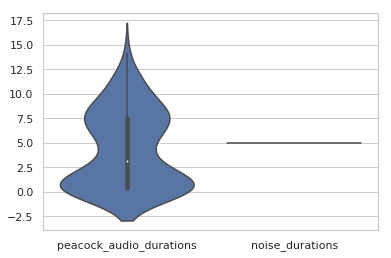

In [164]:
sns.set(style="whitegrid")
ax = sns.violinplot(data=dafr)

In [165]:
fn,features,final_labels,label,label1,label2 = parse_audio_files2(parent_dir,sub_dirs)

/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [166]:
final_labels.shape

(1242, 3)

In [167]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from numpy import argmax
from keras.utils import to_categorical
from keras import initializers

one_hot1 = LabelBinarizer()
# One-hot encode data
label_ = one_hot1.fit_transform(label)
label_1 = one_hot1.fit_transform(label1)
#print(one_hot1.classes_)print(label_)print(label_1)
one_hot2 = MultiLabelBinarizer()
# One-hot encode data
label_2 = one_hot2.fit_transform(label2)
label__2 = to_categorical(label2)
#print(label__2)
one_hot2.classes_

array(['0', '1', '2', '3', '4'], dtype=object)

In [168]:
print(label__2.shape)
print(label_1.shape)
print(label_.shape)
print(label_2.shape)

(1242, 5)
(1242, 1)
(1242, 1)
(1242, 5)


In [169]:
dafr_labels = pd.DataFrame()
dafr_labels["file_name"] = fn
dafr_labels["peacock"] = label_
dafr_labels["disturbance"] = label_1
#dafr_labels["single_peacock"] = [label__2]

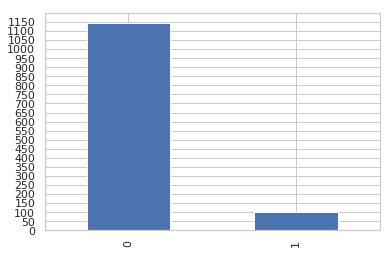

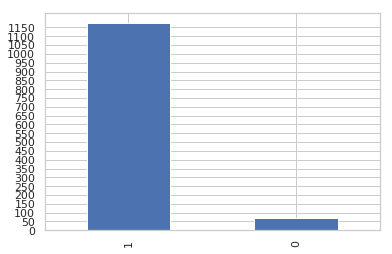

In [170]:
dafr_labels['peacock'].value_counts().plot(kind='bar')
            #,'disturbance','single_peacock']].plot(kind='bar')
#plt.xticks(np.arange(0, 51, 5)) 
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
dafr_labels['disturbance'].value_counts().plot(kind='bar')
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
#dafr_labels['single_peacock'].value_counts().plot(kind='bar')
#plt.yticks(np.arange(0, 1200, 25)) 
#plt.show()

In [171]:
pd.Series(label).value_counts()

0    1143
1      99
dtype: int64

In [172]:
pd.Series(label1).value_counts()

1    1174
0      68
dtype: int64

In [173]:
pd.Series(label2).value_counts()

0    1146
1      48
2      41
4       4
3       3
dtype: int64

# MLP keras 

In [174]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten, Dropout, BatchNormalization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D
#from keras import regularizers, optimizer
import pandas as pd
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,multilabel_confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import backend as K
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

my_init = initializers.glorot_uniform(seed=42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [175]:
X_train, X_test, y1_train, y1_test,y2_train,y2_test,y3_train,y3_test = train_test_split(features,
                                            label_,label_1,label__2, test_size=0.33, random_state=42)

In [176]:
print(y3_train.shape)
print(y3_test.shape)

(832, 5)
(410, 5)


## Multi output neural network

In [180]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [178]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [181]:
#create the model
inn = Input(shape = (193,))
x = Sequential()(inn)
# Adding the input layer and the first hidden layer
x = Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193)(x)
# Adding the second hidden layer
x=Dense(output_dim = 20, init = 'uniform', activation = 'relu')(x)
x= Dense(output_dim = 8, init = 'uniform', activation = 'relu')(x)
# Adding the output layer
out1 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out2 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out3 =Dense(output_dim = 5, init = 'uniform', activation = 'softmax')(x)
# Compiling Neural Network
model = Model(inputs=[inn], outputs=[out1, out2,out3])
#classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# compile the model
model.compile(optimizer='adam', loss=['binary_crossentropy','binary_crossentropy','categorical_crossentropy'],
              metrics=[f1_m,f1_m,f1_m])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=193, units=40, kernel_initializer="uniform")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=20, kernel_initializer="uniform")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid",

In [182]:
class_weights = {0: 1.08377,
                1: 25.875,
                2: 30.3,
                3: 414,
                4: 310.5} # w(i) = N/n(i)

In [183]:
# fit the model
history = model.fit(X_train, [y1_train,y2_train,y3_train],
                    validation_split=0.3, epochs=100,batch_size = 10, verbose=1,class_weight=class_weights)

Train on 582 samples, validate on 250 samples
Epoch 1/100
582/582 [==============================] - 2s 3ms/step - loss: 1.9229 - dense_34_loss: 0.4862 - dense_35_loss: 0.4353 - dense_36_loss: 1.0013 - dense_34_f1_m: 0.0000e+00 - dense_34_f1_m_1: 0.0000e+00 - dense_34_f1_m_2: 0.0000e+00 - dense_35_f1_m: 0.9670 - dense_35_f1_m_1: 0.9670 - dense_35_f1_m_2: 0.9670 - dense_36_f1_m: 0.4118 - dense_36_f1_m_1: 0.4118 - dense_36_f1_m_2: 0.4118 - val_loss: 0.8554 - val_dense_34_loss: 0.2497 - val_dense_35_loss: 0.2453 - val_dense_36_loss: 0.3604 - val_dense_34_f1_m: 0.0000e+00 - val_dense_34_f1_m_1: 0.0000e+00 - val_dense_34_f1_m_2: 0.0000e+00 - val_dense_35_f1_m: 0.9673 - val_dense_35_f1_m_1: 0.9673 - val_dense_35_f1_m_2: 0.9673 - val_dense_36_f1_m: 0.9280 - val_dense_36_f1_m_1: 0.9280 - val_dense_36_f1_m_2: 0.9280
Epoch 2/100
582/582 [==============================] - 0s 825us/step - loss: 0.7276 - dense_34_loss: 0.2448 - dense_35_loss: 0.1753 - dense_36_loss: 0.3076 - dense_34_f1_m: 0.0000e+

Epoch 12/100
582/582 [==============================] - 0s 826us/step - loss: 0.1812 - dense_34_loss: 0.0244 - dense_35_loss: 0.0664 - dense_36_loss: 0.0903 - dense_34_f1_m: 0.4983 - dense_34_f1_m_1: 0.4983 - dense_34_f1_m_2: 0.4983 - dense_35_f1_m: 0.9796 - dense_35_f1_m_1: 0.9796 - dense_35_f1_m_2: 0.9796 - dense_36_f1_m: 0.9526 - dense_36_f1_m_1: 0.9526 - dense_36_f1_m_2: 0.9526 - val_loss: 0.4379 - val_dense_34_loss: 0.1072 - val_dense_35_loss: 0.1221 - val_dense_36_loss: 0.2086 - val_dense_34_f1_m: 0.4267 - val_dense_34_f1_m_1: 0.4267 - val_dense_34_f1_m_2: 0.4267 - val_dense_35_f1_m: 0.9866 - val_dense_35_f1_m_1: 0.9866 - val_dense_35_f1_m_2: 0.9866 - val_dense_36_f1_m: 0.9509 - val_dense_36_f1_m_1: 0.9509 - val_dense_36_f1_m_2: 0.9509
Epoch 13/100
582/582 [==============================] - 1s 904us/step - loss: 0.2922 - dense_34_loss: 0.0737 - dense_35_loss: 0.0888 - dense_36_loss: 0.1297 - dense_34_f1_m: 0.4519 - dense_34_f1_m_1: 0.4519 - dense_34_f1_m_2: 0.4519 - dense_35_f1_m

Epoch 23/100
582/582 [==============================] - 1s 897us/step - loss: 0.1346 - dense_34_loss: 0.0033 - dense_35_loss: 0.0551 - dense_36_loss: 0.0761 - dense_34_f1_m: 0.4983 - dense_34_f1_m_1: 0.4983 - dense_34_f1_m_2: 0.4983 - dense_35_f1_m: 0.9819 - dense_35_f1_m_1: 0.9819 - dense_35_f1_m_2: 0.9819 - dense_36_f1_m: 0.9578 - dense_36_f1_m_1: 0.9578 - dense_36_f1_m_2: 0.9578 - val_loss: 0.5222 - val_dense_34_loss: 0.1440 - val_dense_35_loss: 0.1466 - val_dense_36_loss: 0.2316 - val_dense_34_f1_m: 0.4267 - val_dense_34_f1_m_1: 0.4267 - val_dense_34_f1_m_2: 0.4267 - val_dense_35_f1_m: 0.9843 - val_dense_35_f1_m_1: 0.9843 - val_dense_35_f1_m_2: 0.9843 - val_dense_36_f1_m: 0.9535 - val_dense_36_f1_m_1: 0.9535 - val_dense_36_f1_m_2: 0.9535
Epoch 24/100
582/582 [==============================] - 0s 847us/step - loss: 0.1322 - dense_34_loss: 0.0032 - dense_35_loss: 0.0547 - dense_36_loss: 0.0744 - dense_34_f1_m: 0.5670 - dense_34_f1_m_1: 0.5670 - dense_34_f1_m_2: 0.5670 - dense_35_f1_m

Epoch 34/100
582/582 [==============================] - 1s 888us/step - loss: 0.1319 - dense_34_loss: 0.0020 - dense_35_loss: 0.0505 - dense_36_loss: 0.0793 - dense_34_f1_m: 0.5498 - dense_34_f1_m_1: 0.5498 - dense_34_f1_m_2: 0.5498 - dense_35_f1_m: 0.9845 - dense_35_f1_m_1: 0.9845 - dense_35_f1_m_2: 0.9845 - dense_36_f1_m: 0.9516 - dense_36_f1_m_1: 0.9516 - dense_36_f1_m_2: 0.9516 - val_loss: 0.5523 - val_dense_34_loss: 0.1572 - val_dense_35_loss: 0.1614 - val_dense_36_loss: 0.2338 - val_dense_34_f1_m: 0.4267 - val_dense_34_f1_m_1: 0.4267 - val_dense_34_f1_m_2: 0.4267 - val_dense_35_f1_m: 0.9869 - val_dense_35_f1_m_1: 0.9869 - val_dense_35_f1_m_2: 0.9869 - val_dense_36_f1_m: 0.9579 - val_dense_36_f1_m_1: 0.9579 - val_dense_36_f1_m_2: 0.9579
Epoch 35/100
582/582 [==============================] - 0s 791us/step - loss: 0.1281 - dense_34_loss: 0.0011 - dense_35_loss: 0.0528 - dense_36_loss: 0.0742 - dense_34_f1_m: 0.6186 - dense_34_f1_m_1: 0.6186 - dense_34_f1_m_2: 0.6186 - dense_35_f1_m

Epoch 45/100
582/582 [==============================] - 0s 829us/step - loss: 0.1551 - dense_34_loss: 0.0134 - dense_35_loss: 0.0627 - dense_36_loss: 0.0791 - dense_34_f1_m: 0.4731 - dense_34_f1_m_1: 0.4731 - dense_34_f1_m_2: 0.4731 - dense_35_f1_m: 0.9813 - dense_35_f1_m_1: 0.9813 - dense_35_f1_m_2: 0.9813 - dense_36_f1_m: 0.9522 - dense_36_f1_m_1: 0.9522 - dense_36_f1_m_2: 0.9522 - val_loss: 0.5779 - val_dense_34_loss: 0.1857 - val_dense_35_loss: 0.1391 - val_dense_36_loss: 0.2532 - val_dense_34_f1_m: 0.4053 - val_dense_34_f1_m_1: 0.4053 - val_dense_34_f1_m_2: 0.4053 - val_dense_35_f1_m: 0.9824 - val_dense_35_f1_m_1: 0.9824 - val_dense_35_f1_m_2: 0.9824 - val_dense_36_f1_m: 0.9438 - val_dense_36_f1_m_1: 0.9438 - val_dense_36_f1_m_2: 0.9438
Epoch 46/100
582/582 [==============================] - 0s 795us/step - loss: 0.1346 - dense_34_loss: 0.0027 - dense_35_loss: 0.0537 - dense_36_loss: 0.0782 - dense_34_f1_m: 0.6186 - dense_34_f1_m_1: 0.6186 - dense_34_f1_m_2: 0.6186 - dense_35_f1_m

Epoch 56/100
582/582 [==============================] - 0s 824us/step - loss: 0.1294 - dense_34_loss: 0.0012 - dense_35_loss: 0.0506 - dense_36_loss: 0.0776 - dense_34_f1_m: 0.5017 - dense_34_f1_m_1: 0.5017 - dense_34_f1_m_2: 0.5017 - dense_35_f1_m: 0.9843 - dense_35_f1_m_1: 0.9843 - dense_35_f1_m_2: 0.9843 - dense_36_f1_m: 0.9569 - dense_36_f1_m_1: 0.9569 - dense_36_f1_m_2: 0.9569 - val_loss: 0.5906 - val_dense_34_loss: 0.1673 - val_dense_35_loss: 0.1742 - val_dense_36_loss: 0.2491 - val_dense_34_f1_m: 0.4133 - val_dense_34_f1_m_1: 0.4133 - val_dense_34_f1_m_2: 0.4133 - val_dense_35_f1_m: 0.9866 - val_dense_35_f1_m_1: 0.9866 - val_dense_35_f1_m_2: 0.9866 - val_dense_36_f1_m: 0.9587 - val_dense_36_f1_m_1: 0.9587 - val_dense_36_f1_m_2: 0.9587
Epoch 57/100
582/582 [==============================] - 0s 786us/step - loss: 0.1282 - dense_34_loss: 2.1516e-04 - dense_35_loss: 0.0514 - dense_36_loss: 0.0766 - dense_34_f1_m: 0.5326 - dense_34_f1_m_1: 0.5326 - dense_34_f1_m_2: 0.5326 - dense_35_

Epoch 67/100
582/582 [==============================] - 0s 839us/step - loss: 0.1284 - dense_34_loss: 8.3185e-04 - dense_35_loss: 0.0516 - dense_36_loss: 0.0760 - dense_34_f1_m: 0.4983 - dense_34_f1_m_1: 0.4983 - dense_34_f1_m_2: 0.4983 - dense_35_f1_m: 0.9830 - dense_35_f1_m_1: 0.9830 - dense_35_f1_m_2: 0.9830 - dense_36_f1_m: 0.9560 - dense_36_f1_m_1: 0.9560 - dense_36_f1_m_2: 0.9560 - val_loss: 0.5603 - val_dense_34_loss: 0.1508 - val_dense_35_loss: 0.1770 - val_dense_36_loss: 0.2325 - val_dense_34_f1_m: 0.4267 - val_dense_34_f1_m_1: 0.4267 - val_dense_34_f1_m_2: 0.4267 - val_dense_35_f1_m: 0.9819 - val_dense_35_f1_m_1: 0.9819 - val_dense_35_f1_m_2: 0.9819 - val_dense_36_f1_m: 0.9527 - val_dense_36_f1_m_1: 0.9527 - val_dense_36_f1_m_2: 0.9527
Epoch 68/100
582/582 [==============================] - 0s 792us/step - loss: 0.1290 - dense_34_loss: 7.2392e-04 - dense_35_loss: 0.0524 - dense_36_loss: 0.0758 - dense_34_f1_m: 0.6357 - dense_34_f1_m_1: 0.6357 - dense_34_f1_m_2: 0.6357 - dense

Epoch 78/100
582/582 [==============================] - 0s 799us/step - loss: 0.2171 - dense_34_loss: 0.0404 - dense_35_loss: 0.0713 - dense_36_loss: 0.1054 - dense_34_f1_m: 0.4811 - dense_34_f1_m_1: 0.4811 - dense_34_f1_m_2: 0.4811 - dense_35_f1_m: 0.9822 - dense_35_f1_m_1: 0.9822 - dense_35_f1_m_2: 0.9822 - dense_36_f1_m: 0.9537 - dense_36_f1_m_1: 0.9537 - dense_36_f1_m_2: 0.9537 - val_loss: 0.6417 - val_dense_34_loss: 0.2039 - val_dense_35_loss: 0.1707 - val_dense_36_loss: 0.2671 - val_dense_34_f1_m: 0.4133 - val_dense_34_f1_m_1: 0.4133 - val_dense_34_f1_m_2: 0.4133 - val_dense_35_f1_m: 0.9827 - val_dense_35_f1_m_1: 0.9827 - val_dense_35_f1_m_2: 0.9827 - val_dense_36_f1_m: 0.9430 - val_dense_36_f1_m_1: 0.9430 - val_dense_36_f1_m_2: 0.9430
Epoch 79/100
582/582 [==============================] - 0s 791us/step - loss: 0.1635 - dense_34_loss: 0.0202 - dense_35_loss: 0.0555 - dense_36_loss: 0.0877 - dense_34_f1_m: 0.5647 - dense_34_f1_m_1: 0.5647 - dense_34_f1_m_2: 0.5647 - dense_35_f1_m

Epoch 89/100
582/582 [==============================] - 0s 793us/step - loss: 0.1256 - dense_34_loss: 6.2240e-04 - dense_35_loss: 0.0485 - dense_36_loss: 0.0765 - dense_34_f1_m: 0.5326 - dense_34_f1_m_1: 0.5326 - dense_34_f1_m_2: 0.5326 - dense_35_f1_m: 0.9836 - dense_35_f1_m_1: 0.9836 - dense_35_f1_m_2: 0.9836 - dense_36_f1_m: 0.9610 - dense_36_f1_m_1: 0.9610 - dense_36_f1_m_2: 0.9610 - val_loss: 0.5656 - val_dense_34_loss: 0.1481 - val_dense_35_loss: 0.1766 - val_dense_36_loss: 0.2409 - val_dense_34_f1_m: 0.4267 - val_dense_34_f1_m_1: 0.4267 - val_dense_34_f1_m_2: 0.4267 - val_dense_35_f1_m: 0.9819 - val_dense_35_f1_m_1: 0.9819 - val_dense_35_f1_m_2: 0.9819 - val_dense_36_f1_m: 0.9602 - val_dense_36_f1_m_1: 0.9602 - val_dense_36_f1_m_2: 0.9602
Epoch 90/100
582/582 [==============================] - 0s 838us/step - loss: 0.1227 - dense_34_loss: 7.7319e-04 - dense_35_loss: 0.0472 - dense_36_loss: 0.0747 - dense_34_f1_m: 0.5155 - dense_34_f1_m_1: 0.5155 - dense_34_f1_m_2: 0.5155 - dense

Epoch 100/100
582/582 [==============================] - 0s 791us/step - loss: 0.1107 - dense_34_loss: 0.0013 - dense_35_loss: 0.0383 - dense_36_loss: 0.0711 - dense_34_f1_m: 0.5842 - dense_34_f1_m_1: 0.5842 - dense_34_f1_m_2: 0.5842 - dense_35_f1_m: 0.9926 - dense_35_f1_m_1: 0.9926 - dense_35_f1_m_2: 0.9926 - dense_36_f1_m: 0.9706 - dense_36_f1_m_1: 0.9706 - dense_36_f1_m_2: 0.9706 - val_loss: 0.6421 - val_dense_34_loss: 0.2130 - val_dense_35_loss: 0.1709 - val_dense_36_loss: 0.2582 - val_dense_34_f1_m: 0.4187 - val_dense_34_f1_m_1: 0.4187 - val_dense_34_f1_m_2: 0.4187 - val_dense_35_f1_m: 0.9845 - val_dense_35_f1_m_1: 0.9845 - val_dense_35_f1_m_2: 0.9845 - val_dense_36_f1_m: 0.9438 - val_dense_36_f1_m_1: 0.9438 - val_dense_36_f1_m_2: 0.9438


In [184]:
# evaluate the model
f1score = model.evaluate(X_test, [y1_test,y2_test,y3_test])
#classifier =KerasClassifier(build_fn=making_model(193), epochs=100, batch_size=10, verbose=0)

410/410 [==============================] - 0s 89us/step


In [185]:
#f1score

In [186]:
yy1,yy2,yy3 = model.predict(X_test)

In [187]:
shape = yy3.shape
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        if yy3[i, j] >= 0.5:
            yy3[i, j] = 1
        else:
            yy3[i, j] = 0
for i in range(0, shape[0]):
        if yy2[i, 0] >= 0.5:
            yy2[i, 0] = 1
        else:
            yy2[i, 0] = 0
for i in range(0, shape[0]):
        if yy1[i, 0] >= 0.5:
            yy1[i, 0] = 1
        else:
            yy1[i, 0] = 0     


In [188]:
res_pred=np.empty(shape=(len(yy3),1),dtype=int)
res_ex = np.empty(shape=(len(yy3),1),dtype=int)

In [189]:
for i in range(len(yy3)):
    res_pred[i] = argmax(yy3[i])
    res_ex[i] = argmax(y3_test[i])
    #print(argmax(yy3[i]))
    #print(y3_test[i])
    #print("--------------------------------------------")

In [190]:
print(confusion_matrix(y1_test,yy1))
print(classification_report(y1_test,yy1))

[[368   7]
 [  6  29]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       375
           1       0.81      0.83      0.82        35

    accuracy                           0.97       410
   macro avg       0.89      0.90      0.90       410
weighted avg       0.97      0.97      0.97       410



In [191]:
print(confusion_matrix(y2_test,yy2))
print(classification_report(y2_test,yy2))

[[ 16   8]
 [ 12 374]]
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1       0.98      0.97      0.97       386

    accuracy                           0.95       410
   macro avg       0.78      0.82      0.79       410
weighted avg       0.96      0.95      0.95       410



In [192]:
confusion_matrix(res_ex,res_pred)

array([[368,   3,   4,   0,   0],
       [  2,  11,   3,   0,   0],
       [  1,  10,   4,   0,   0],
       [  2,   0,   0,   0,   0],
       [  1,   1,   0,   0,   0]])

In [193]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 193)          0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 193)          0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 40)           7760        sequential_6[1][0]               
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 20)           820         dense_31[0][0]                   
__________________________________________________________________________________________________
dense_33 (

In [194]:
print(f1_score(res_ex,res_pred,average='weighted'))
print(precision_score(res_ex,res_pred,average='weighted'))
print(recall_score(res_ex,res_pred,average='weighted'))

0.9309562737351048
0.9304353723751142
0.9341463414634147


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [195]:
print(f1_score(res_ex,res_pred,average='micro'))
print(precision_score(res_ex,res_pred,average='micro'))
print(recall_score(res_ex,res_pred,average='micro'))

0.9341463414634147
0.9341463414634147
0.9341463414634147


In [196]:
accuracy_score(res_ex,res_pred)

0.9341463414634147

In [197]:
print(f1_score(res_ex,res_pred,average='macro'))
print(precision_score(res_ex,res_pred,average='macro'))
print(recall_score(res_ex,res_pred,average='macro'))

0.36538423964911315
0.3575187165775401
0.38709999999999994


In [ ]:
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = classifier
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator,epochs=100,verbose=1)
    y_pred = model.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    return roc_auc_score(y_test, y_pred)
res = fit_predict_balanced_model(X_train, y_train, X_test, y_test)

In [ ]:
classifier

In [ ]:
model

In [ ]:
# Fitting our model 
import eli5
from eli5.sklearn import PermutationImportance

history=model.fit(X_train, y_train,validation_data=(X_test, y_test),nb_epoch = 100)
#history=classifier.fit(X,y,validation_data=(X_test, y_test), batch_size = 10, nb_epoch = 100)
#acc = []
# Predicting the Test set results

In [ ]:
# F1 score
f1_score(y_test,y_pred)